# Demo de "First Order Motion Model for Image Animation" y "Motion co-Segmentation" para animar Caras y/o hacer intercambio de algunas partes
Fuentes: 

https://github.com/AliaksandrSiarohin/first-order-model

https://github.com/AliaksandrSiarohin/motion-cosegmentation

https://github.com/1adrianb/face-alignment


1) Preparar el entorno:

In [1]:
#@title Instalar versión anterior de skimage (se debe reiniciar entorno)
import skimage as pd
print(pd.__version__)

!pip install scikit-image==0.18.1

import skimage as pd
print(pd.__version__)

0.19.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


0.19.3


In [1]:
#@title Instalar ffmpeg
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Clonar paquetes 'first-order-model' y 'motion-cosegmentation'
!git clone https://github.com/AliaksandrSiarohin/first-order-model
print("\nFirst Order Motion Model  instalado.")

!git clone https://github.com/AliaksandrSiarohin/motion-cosegmentation motion-co-seg
print("\nMotion-Cosegmentation instalado.")

Cloning into 'first-order-model'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 337 (delta 15), reused 20 (delta 10), pack-reused 306
Receiving objects: 100% (337/337), 72.16 MiB | 36.47 MiB/s, done.
Resolving deltas: 100% (173/173), done.

First Order Motion Model  instalado.
Cloning into 'motion-co-seg'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 106 (delta 21), reused 13 (delta 13), pack-reused 74
Receiving objects: 100% (106/106), 42.61 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (37/37), done.

Motion-Cosegmentation instalado.


In [3]:
#@title Clonar e instalar paquete 'face-alignment'
!git clone https://github.com/1adrianb/face-alignment
%cd face-alignment
!pip install -r requirements.txt
!python setup.py install

# configura objeto para hacer detección de landmarks en imagen y video
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)#, face_detector='sfd')

print("\n\nFace-alignment instalado.")

Cloning into 'face-alignment'...
remote: Enumerating objects: 1026, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1026 (delta 24), reused 36 (delta 18), pack-reused 969
Receiving objects: 100% (1026/1026), 5.26 MiB | 21.55 MiB/s, done.
Resolving deltas: 100% (625/625), done.
/content/face-alignment
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating face_alignment.egg-info
writing face_alignment.egg-info

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:22<00:00, 4.02MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:05<00:00, 16.6MB/s]




Face-alignment instalado.


In [4]:
#@title Instalar paquete 'imageio-ffmpeg'
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#@title Cargar Librerías
import sys

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

from skimage import io
from skimage import img_as_ubyte

import PIL
from PIL import Image
from IPython.display import display as displayImage
import copy
import os

import torch
import torch.nn.functional as F
import matplotlib.patches as mpatches

print("Librerías cargadas.")

Librerías cargadas.


In [6]:
#@title Montar el drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dir = '/content/gdrive/MyDrive/IA/pruebasDeepFake'  #@param {type:"string"}
subdir_ImagenesyVideos = 'demoCaras' #@param {type:"string"}
subdir_Modelos = 'checkpoints-models' #@param {type:"string"}
dirDatos = dir + '/' + subdir_ImagenesyVideos + '/'
dirModelos = dir + '/' + subdir_Modelos + '/'

Mounted at /content/gdrive


2) Cargar y preparar imagen y video:

In [7]:
#@title Funciones Auxiliares

# tamaño requerido de la imagen y video para paquetes
tamRequeridoModelo = (256, 256)

def hacerCropAuto(im, idCaraDetectada=0, ampliarCrop=0, muestraImg=True):

  # prepara la imagen 
  imagenSinCrop = copy.deepcopy( im )
  input = convImage2Array(im) * 255 
  
  # detecta los elementos de la imagen
  preds = fa.get_landmarks(input)
  if preds == None:
    if muestraImg:  
      print("No se detecta cara!\n")
    return im, None, im

  # busca las coordenadas extremas para el crop
  minX, minY, maxX, maxY = None, None, None, None
  auxID = 0
  leyendasCara = []
  for ar in preds:
    leyendasCara.append( "id_cara_ " + str(auxID) )
    if idCaraDetectada>=0 and idCaraDetectada==auxID:
      for coordX in ar[:,0]:
          if minX == None or coordX < minX:
            minX = int(coordX)
          if maxX == None or coordX > maxX:
            maxX = int(coordX)
      for coordY in ar[:,1]:
          if minY == None or coordY < minY:
            minY = int(coordY)
          if maxY == None or coordY > maxY:
            maxY = int(coordY)
    auxID = auxID + 1 
  if minX == None or maxX == None or minY == None or maxY == None:
    if muestraImg:  
      print("No se encuentra cara_id seleccionada!\n")
    return im, None, im
      
  if muestraImg:
    print("\nLímite de la cara detectada: (", minX,",", minY, ") - (", maxX, ",", maxY, ")\n")
  if ampliarCrop>0:
    minX, maxX = minX-ampliarCrop, maxX+ampliarCrop
    minY, maxY = minY-ampliarCrop, maxY+ampliarCrop

  # controla contra tamaño de la imagen
  if minX < 0:
    minX = 0
  if minY < 0:
    minY = 0
  if maxX > im.size[0]:
    maxX = im.size[0]
  if maxY > im.size[1]:
    maxY = im.size[1]

  # realiza el crop de la imagen
  im = im.crop( (minX, minY, maxX, maxY) ) 

  # muesta la imagen si corresponde
  if muestraImg:
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].imshow(imagenSinCrop)
    for detection in preds:
      ax[0].scatter(detection[:,0], detection[:,1], 5)
    ax[0].legend(leyendasCara)
    ax[1].imshow(im)
    ax[0].axis('off')
    ax[1].axis('off')
  
  return im, (minX, minY), imagenSinCrop


def deshacerCropAuto(hizoCrop, imOrig, imagNueva, coordXY):

  # si está definido hace el crop
  if hizoCrop and coordXY!=None:

    # le hace una copia a la imagen para no perderla
    imOrigCopy = copy.deepcopy( imOrig )

    # copia una imagen en la posición correspondiente a la posición indicada
    imOrigCopy.paste(imagNueva, copy.deepcopy(coordXY) )

    return imOrigCopy  
  
  else:
    return imagNueva
      

def ajustarCoordResize(cords, tamOri, tamNuevo):
  if cords == None:
    return None
  if len(cords) != len(tamOri) or len(cords) != len(tamNuevo):
    return cords
  # realiza el ajuste
  Ncords = []
  for i in range(len(cords)):
    Ncords.append( int( cords[i]/(tamOri[i]/tamNuevo[i]) ) )

  return Ncords

def convImage2Array(im):
  return np.array(im).astype('float32') / 255.0


def convArray2Image(arIm, mult255=True):
  if mult255:
    multiplica = 255.0
  else:
    multiplica = 1.0
  return Image.fromarray((arIm*multiplica).astype(np.uint8))


def displayAnimacion(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        if source is None:
          cols = [ driving[0] ]
        else:
          cols = [ source] 
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani


def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')

    return color_mask

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


/content/gdrive/MyDrive/IA/pruebasDeepFake/demoCaras/monaLisa.jpg
Imagen cargada.
Tamaño original:  (1289, 1913)



Límite de la cara detectada: ( 489 , 417 ) - ( 817 , 700 )

(928, 883)
Nuevo tamaño luego del resize:  (256, 256)
Tamaño del vector de la imagen:  (256, 256, 3)


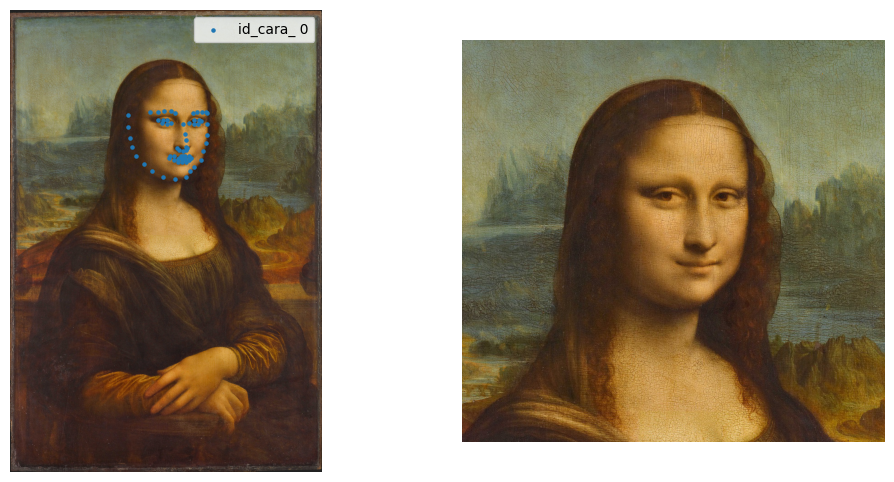

In [8]:
#@title Seleccionar y preparar la imagen

# selecciona la imagen a procesar
imagen_Seleccionada = "monaLisa.jpg" #@param ['sample1-shrek.png', 'sample2-chucky.png' , 'sample3-it.png' , 'sample4-socrates.png','sample5-putin.png','sample6-downeyjr.png', 'sample7-wryder.png', 'sample8.png', 'sample9.png', 'monaLisa.jpg', 'moises.jpg', 'yo.png', 'yoda.jpeg', 'babyYoda.jpeg', 'zombie1.jpg', 'zombie2.jpg' ] {allow-input: false}
imagenFuente = dirDatos + imagen_Seleccionada

imagen_hace_Crop_cara = True #@param {type:"boolean"}
imagen_id_cara_detectada = 0 #@param {type:"number"}
imagen_ampliar_Crop_cara = 300 #@param {type:"number"}
imagen_espejada = True #@param {type:"boolean"}

# carga la imagen
print(imagenFuente)
im = Image.open( imagenFuente )
print("Imagen cargada.")

# fuerza a RGB
im = im.convert("RGB")

# obtiene el tamaño original de la imagen
imgTamOri = im.size
print("Tamaño original: ", imgTamOri)

# realiza imagen espejada (opcional)
if imagen_espejada:
  im = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)

print("\n")
if imagen_hace_Crop_cara: 
  # realiza el crop automatico
  im, imgCoordCrop, imagenSinCrop = hacerCropAuto(im, imagen_id_cara_detectada, imagen_ampliar_Crop_cara)
  imgTamCrop = im.size
  print(imgTamCrop)
  imgHizoCrop = True
else:
  # no realiza el crop automatico
  imagenSinCrop = im
  imgTamCrop = imgTamOri
  imgHizoCrop = False
  imgCoordCrop = None
  displayImage(im)

# cambia tamaño de la imagen a procesar a 256x256
im = im.resize(tamRequeridoModelo, Image.ANTIALIAS)
print("Nuevo tamaño luego del resize: ", im.size)

# ajusta el tamaño de las coordenadas de crop
if imgCoordCrop!=None:
  imgCoordCrop = ajustarCoordResize(imgCoordCrop, imgTamCrop, tamRequeridoModelo)  

# cambia tamaño de la imagen sin crop 
imagenSinCrop = imagenSinCrop.resize( ajustarCoordResize(imgTamOri, imgTamCrop, tamRequeridoModelo), Image.ANTIALIAS)
  
# convierte imagen a vector de números
source_image = convImage2Array(im)
print("Tamaño del vector de la imagen: ", source_image.shape)



/content/gdrive/MyDrive/IA/pruebasDeepFake/demoCaras/jackNicholson.mp4


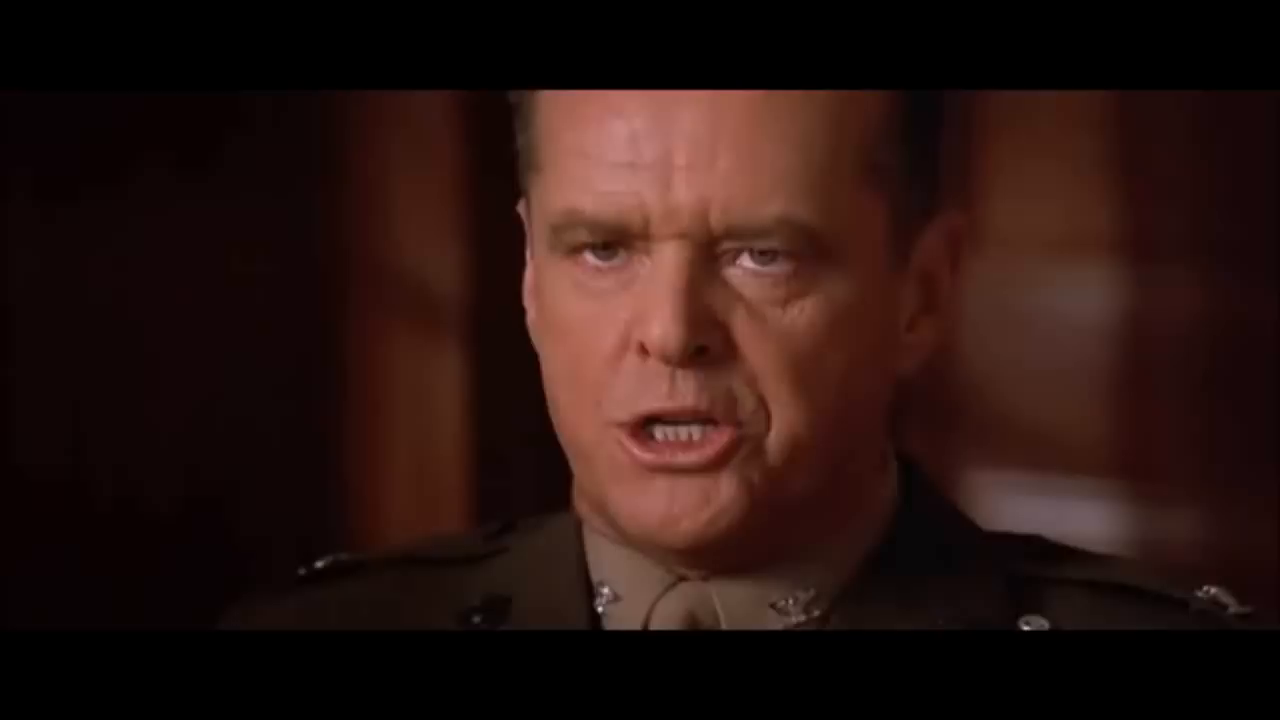

In [9]:
#@title Seleccionar el video y determina parámetros

# selecciona el video a procesar
video_seleccionado =  "jackNicholson.mp4" #@param [ 'sample1-obama.mp4', 'sample2-dicaprio.mp4', 'sample3-trump.mp4', 'sample4.mp4', 'jackNicholson.mp4', 'JimCarrey1.mp4', 'JimCarrey2.mp4'  ] {allow-input: true}
videoFuente = dirDatos + video_seleccionado
print(videoFuente)

video_hace_Crop_cara = False #@param {type:"boolean"}
video_id_cara_detectada = 0 #@param {type:"number"}
video_ampliar_Crop_cara =  80 #@param {type:"number"}
video_tomar_segmento_usar = False #@param {type:"boolean"}
video_ini_segmento_usar = 330 #@param {type:"number"}
video_fin_segmento_usar = 550 #@param {type:"number"}

# carga video
reader = imageio.get_reader( videoFuente )
if videoFuente.find('mp4')>=0:
  fps = reader.get_meta_data()['fps']
else:
  fps = 25
driving_video = []
try:
    auxContador = 0
    for imVideo in reader:
      if not(video_tomar_segmento_usar) or (auxContador >= video_ini_segmento_usar and auxContador <= video_fin_segmento_usar): 
        # aplica el crop si corresponde 
        # y muestra solo la primera imagen como ejemplo
        img = convArray2Image(imVideo, mult255=False)
        if video_hace_Crop_cara:
          img, _, _ = hacerCropAuto(img, video_id_cara_detectada, video_ampliar_Crop_cara)
        else:
           displayImage(img)
        # cambia el tamaño de la imagen
        img = img.resize(tamRequeridoModelo, Image.ANTIALIAS)                
        break
      auxContador = auxContador + 1
except RuntimeError:
    pass
reader.close()

In [10]:
#@title Preparar todo el video

# carga video
reader = imageio.get_reader( videoFuente )
if videoFuente.find('mp4')>=0:
  fps = reader.get_meta_data()['fps']
else:
  fps = 15
driving_video = []
driving_video_sinCrop = []
driving_video_coordsCrop = []
try:
    i = 0
    auxContador = 0
    for imVideo in reader:  
      if not(video_tomar_segmento_usar) or (auxContador >= video_ini_segmento_usar and auxContador <= video_fin_segmento_usar): 
        # procesa los frames y las agrega al vector    
        img = convArray2Image(imVideo, mult255=False)
        # hace el crop si corresponde y guarda info 
        # para reconstruir luego imagen original        
        if video_hace_Crop_cara:
          img, coordCrop, imgOri = hacerCropAuto(img, video_id_cara_detectada, video_ampliar_Crop_cara, False)
          #coordCrop = ajustarCoordResize(coordCrop, imgOri.size, tamRequeridoModelo)  
          driving_video_coordsCrop.append( coordCrop )
          #imgOri = imgOri.resize( ajustarCoordResize(imgOri.size, img.size, tamRequeridoModelo), Image.ANTIALIAS)
          driving_video_sinCrop.append( imgOri )
        # cambia el tamaño de la imagen
        img = img.resize(tamRequeridoModelo, Image.ANTIALIAS)
        # agrega el frame a la lista
        driving_video.append( convImage2Array(img) )      
      auxContador = auxContador + 1
except RuntimeError:
    pass
reader.close()

print("Video cargado.")
print("Duración del video total: ", len(driving_video), " frames.")

# cambia tamaño del video a 256x256
##driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# muestra imagen con video
HTML(displayAnimacion(source_image, driving_video).to_html5_video())

Video cargado.
Duración del video total:  100  frames.


3) Genera la animación de la cara de la imagen con gesto del video:

In [11]:
#@title Cargar checkpoint del modelo 'first-order-mode' ya entrenado

if '/content/motion-co-seg' in sys.path:
  sys.path.remove('/content/motion-co-seg')
if '/content/motion-co-seg/modules' in sys.path:
  sys.path.remove('/content/motion-co-seg/modules')
# tiene que borrar este modulo que está en ambos paquetes 
# pero con diferente veriones
if "logger" in sys.modules:
  del sys.modules["logger"]

sys.path.append('/content/first-order-model')
sys.path.append('/content/first-order-model/modules')
from demo import make_animation

# redefine porque sino falla por no usar "yaml.safe_load"
#from demo import load_checkpoints as fom_load_checkpoints
import yaml
from modules.generator import OcclusionAwareGenerator
from modules.keypoint_detector import KPDetector
from animate import normalize_kp
from scipy.spatial import ConvexHull
from sync_batchnorm import DataParallelWithCallback
def nfom_load_checkpoints(config_path, checkpoint_path, cpu=False):

    with open(config_path) as f:
        config = yaml.safe_load(f) # cambio

    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
    if not cpu:
        generator.cuda()

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])
    if not cpu:
        kp_detector.cuda()
    
    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
 
    generator.load_state_dict(checkpoint['generator'])
    kp_detector.load_state_dict(checkpoint['kp_detector'])
    
    if not cpu:
        generator = DataParallelWithCallback(generator)
        kp_detector = DataParallelWithCallback(kp_detector)

    generator.eval()
    kp_detector.eval()
    
    return generator, kp_detector


print("Librerías cargadas de 'first-order-mode'.")


generator, kp_detector = nfom_load_checkpoints(config_path = '/content/first-order-model/config/vox-256.yaml', 
                            checkpoint_path = dirModelos + 'vox-cpk.pth.tar')

print("Modelo 'first-order-mode' cargado.")

Librerías cargadas de 'first-order-mode'.
Modelo 'first-order-mode' cargado.


In [12]:
#@title Aplica el modelo para generar nueva animación

# genera animación aplicando el modelo
tipo_Desplazamiento = 'relativo'  #@param ['relativo', 'absoluto']
if tipo_Desplazamiento == 'relativo': 
  # usa desplazamientos relativos (queda mejor)
  predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)
else:
  # usa desplazamientos relativos (queda deformado)
  predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, adapt_movement_scale=True)

# muestra la animación
HTML(displayAnimacion(source_image, driving_video, predictions).to_html5_video())

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
#@title Agrega bordes de la imagen en la animación (si corresponde)

animacion = []
if imgHizoCrop:
  
  # toma los frames de la animación generada
  # y las inserta dentro de la imagen original
  # para generar animación mejorada
  for imP in predictions:
    img = convArray2Image(imP, mult255=True)
    nImag = deshacerCropAuto(imgHizoCrop, imagenSinCrop, img, imgCoordCrop)
    animacion.append( convImage2Array(nImag) ) 
else:
  # como no se hizo crop, no hace nada
  animacion = predictions

HTML(displayAnimacion(None, animacion).to_html5_video())  

In [20]:
#@title Exporta la animación

if animacion == None:
  animacion = predictions

# graba el video para poder bajarlo (opcional)
tipoExportacion = "no" #@param ["no", "GIF", "MP4"]
if tipoExportacion != "no":
  expName = '/content/' + 'vfake_' + tipo_Desplazamiento[:3] + '_' + os.path.splitext(imagen_Seleccionada)[0] + '_' + os.path.splitext(video_seleccionado)[0]   
  if tipoExportacion == "MP4":
    expName = expName + '.mp4'
  elif tipoExportacion == "GIF":
    expName = expName + '.gif'
  imageio.mimsave(expName, [img_as_ubyte(frame) for frame in animacion], fps=fps)
  print(expName, " generado en el disco temporal del ambiente.")

#HTML(displayAnimacion(None, animacion).to_html5_video())

4) Genera la animación con intercambio de elementos:

In [15]:
#@title Cargar checkpoint del modelo 'motion-co-seg' ya entrenado


if '/content/first-order-model' in sys.path:
  sys.path.remove('/content/first-order-model')
if '/content/first-order-model/modules' in sys.path:
  sys.path.remove('/content/first-order-model/modules')
# tiene que borrar este modulo que está en ambos paquetes 
# pero con diferente veriones
if "logger" in sys.modules:
  del sys.modules["logger"]

sys.path.append('/content/motion-co-seg')
sys.path.append('/content/motion-co-seg/modules')


# cambia por error
#from part_swap import load_checkpoints as swap_load_checkpoints
from part_swap import PartSwapGenerator
from modules.segmentation_module import SegmentationModule
from modules.reconstruction_module import ReconstructionModule
from sync_batchnorm import DataParallelWithCallback


# define funciones auxiliares de logger 
def partial_state_dict_load(module, state_dict):
    own_state = module.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
            continue
 
        if isinstance(param, torch.nn.Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)

def load_reconstruction_module(module, checkpoint):
    if 'generator' in checkpoint:
        partial_state_dict_load(module, checkpoint['generator'])
    else:
        module.load_state_dict(checkpoint['reconstruction_module'])


def load_segmentation_module(module, checkpoint):
    if 'kp_detector' in checkpoint:
        partial_state_dict_load(module, checkpoint['kp_detector'])
        module.state_dict()['affine.weight'].copy_(checkpoint['kp_detector']['jacobian.weight'])
        module.state_dict()['affine.bias'].copy_(checkpoint['kp_detector']['jacobian.bias'])
        module.state_dict()['shift.weight'].copy_(checkpoint['kp_detector']['kp.weight'])
        module.state_dict()['shift.bias'].copy_(checkpoint['kp_detector']['kp.bias'])
        if 'semantic_seg.weight' in checkpoint['kp_detector']:
            module.state_dict()['segmentation.weight'].copy_(checkpoint['kp_detector']['semantic_seg.weight'])
            module.state_dict()['segmentation.bias'].copy_(checkpoint['kp_detector']['semantic_seg.bias'])
        else:
            print ('Segmentation part initialized at random.')
    else:
        module.load_state_dict(checkpoint['segmentation_module'])



def nswap_load_checkpoints(config, checkpoint, blend_scale=0.125, first_order_motion_model=False, cpu=False):
    with open(config) as f:
        config = yaml.safe_load(f) #cambia

    reconstruction_module = PartSwapGenerator(blend_scale=blend_scale,
                                              first_order_motion_model=first_order_motion_model,
                                              **config['model_params']['reconstruction_module_params'],
                                              **config['model_params']['common_params'])

    if not cpu:
        reconstruction_module.cuda()

    segmentation_module = SegmentationModule(**config['model_params']['segmentation_module_params'],
                                             **config['model_params']['common_params'])
    if not cpu:
        segmentation_module.cuda()

    if cpu:
        checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint)

    load_reconstruction_module(reconstruction_module, checkpoint)
    load_segmentation_module(segmentation_module, checkpoint)

    if not cpu:
        reconstruction_module = DataParallelWithCallback(reconstruction_module)
        segmentation_module = DataParallelWithCallback(segmentation_module)

    reconstruction_module.eval()
    segmentation_module.eval()

    return reconstruction_module, segmentation_module



from part_swap import make_video

print("Librerías cargadas de 'motion-co-seg'.")

#%cd /content/motion-co-seg
tipo_checkpoint_de_intercambio = "10 segmentos" 
if  tipo_checkpoint_de_intercambio == "10 segmentos":
  configSgmt = '/content/motion-co-seg/config/vox-256-sem-10segments.yaml'
  chpntSgmto = dirModelos + 'vox-10segments.pth.tar'
# Nota: hay también de 5 y 15 segmentos pero como ejemplo se usa solo este
# en caso que se desea usar alguno de los otros, bajar de la fuente y subir al drive

reconstruction_module, segmentation_module = nswap_load_checkpoints(config = configSgmt, 
                                               checkpoint = chpntSgmto,
                                               blend_scale = 1)

print("Modelo 'motion-co-seg' cargado.")

Librerías cargadas de 'motion-co-seg'.
Modelo 'motion-co-seg' cargado.


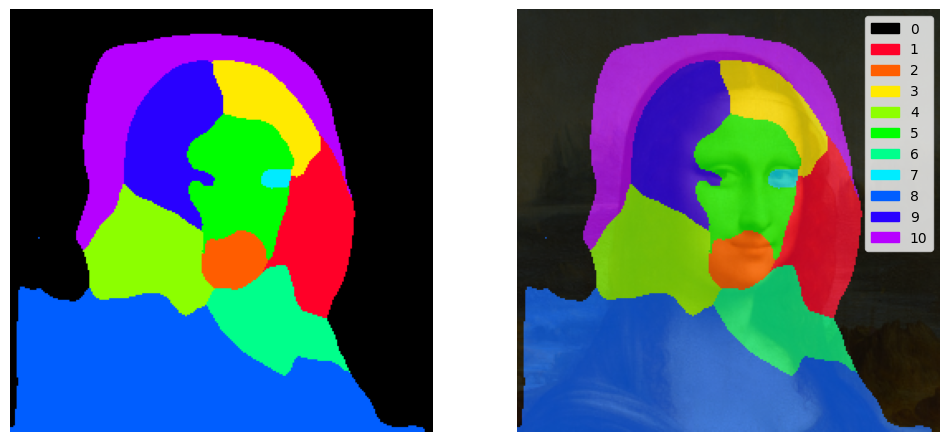

In [16]:
#@title Mostrar segmentos detectados en la imagen

%matplotlib inline
visualize_segmentation(source_image, segmentation_module, hard=True)
plt.show()


In [21]:
#@title Aplica los segmentos seleccionados de la imagen en el video

lista_segmentos_intercambiar = "1,3,4,5,6,8,10" #@param {type:"string"}
swap_index_list = np.array(lista_segmentos_intercambiar.split(",")).astype(np.uint8)
if len(swap_index_list) == 0:
  swap_index_list.append( 1 )
else:
  swap_index_list.sort()

# genera animación aplicando las partes seleccionadas de la imagen
swap_predictions = make_video(swap_index=swap_index_list.tolist(), source_image = source_image, target_video = driving_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
swap_animacion = None

# muestra la animación
HTML(displayAnimacion(source_image, driving_video, swap_predictions).to_html5_video())

100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


In [23]:
#@title Agrega bordes del video en la animación (si corresponde)

swap_animacion = []
if len(driving_video_sinCrop)>0 and len(driving_video_coordsCrop)>0:
  # toma los frames de la animación generada
  # y las inserta dentro de la imagen original
  # para generar animación mejorada
  for i in range(len(swap_predictions)):
    img = convArray2Image(swap_predictions[i], mult255=True)
    nImag = deshacerCropAuto(True, driving_video_sinCrop[i], img, driving_video_coordsCrop[i])
    swap_animacion.append( convImage2Array(nImag) ) 
else:
  # como no se hizo crop, no hace nada
  swap_animacion = swap_predictions

HTML(displayAnimacion(None, swap_animacion).to_html5_video())  

In [22]:
#@title Exporta la animación
# graba el video para poder bajarlo (opcional)

if swap_animacion == None:
  swap_animacion = swap_predictions

tipoExportacion = "no" #@param ["no", "GIF", "MP4"]
if tipoExportacion != "no":
  expName = '/content/' + 'vfake_swap_' + os.path.splitext(imagen_Seleccionada)[0] + '_' + os.path.splitext(video_seleccionado)[0]   
  if tipoExportacion == "MP4":
    expName = expName + '.mp4'
  elif tipoExportacion == "GIF":
    expName = expName + '.gif'
  imageio.mimsave(expName, [img_as_ubyte(frame) for frame in swap_animacion], fps=fps)
  print(expName, " generado en el disco temporal del ambiente.")

#HTML(displayAnimacion(None, swap_animacion).to_html5_video())